In [ ]:
!pip install opendatasets

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset
from torchvision import transforms

import matplotlib.pyplot as plt

import opendatasets as od

from sklearn.model_selection import train_test_split

from PIL import Image

import os

In [ ]:
od.download("https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/download?datasetVersionNumber=1")

Skipping, found downloaded files in "./brain-mri-images-for-brain-tumor-detection" (use force=True to force download)


In [ ]:
# Model Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 50

# Architecture Parameter
NUM_CLASSES = 2


# Define paths for class 1 and class 2 images
path_class_yes = "/content/brain-mri-images-for-brain-tumor-detection/yes"
path_class_no = "/content/brain-mri-images-for-brain-tumor-detection/no"

# CPU OR GPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.target_size = (224, 224)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        label = torch.tensor(self.labels[idx])

        if self.transform:
            image = self.transform(image)
        image = transforms.Resize(self.target_size)(image)
        return image, label


In [ ]:
# List all image paths and corresponding labels
image_paths_yes = [os.path.join(path_class_yes, img) for img in os.listdir(path_class_yes)]
labels_yes = [1] * len(image_paths_yes)

image_paths_no = [os.path.join(path_class_no, img) for img in os.listdir(path_class_no)]
labels_no = [0] * len(image_paths_no)

# Combine paths and labels
all_image_paths = image_paths_yes + image_paths_no
all_labels = labels_yes + labels_no

In [ ]:
# Split the data into training, validation, and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.1, random_state=42, stratify=train_labels
)

In [ ]:
# Define transformations suitable for medical imaging
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
# Create datasets for training, validation, and testing
train_dataset = CustomDataset(train_paths, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_paths, val_labels, transform=val_transform)
test_dataset = CustomDataset(test_paths, test_labels, transform=test_transform)

In [ ]:
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img, label = dataset[i]
        axes[i].imshow(transforms.ToPILImage()(img), cmap='gray')
        axes[i].set_title("Yes" if label.item() == 1 else "No")
        axes[i].axis('off')
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


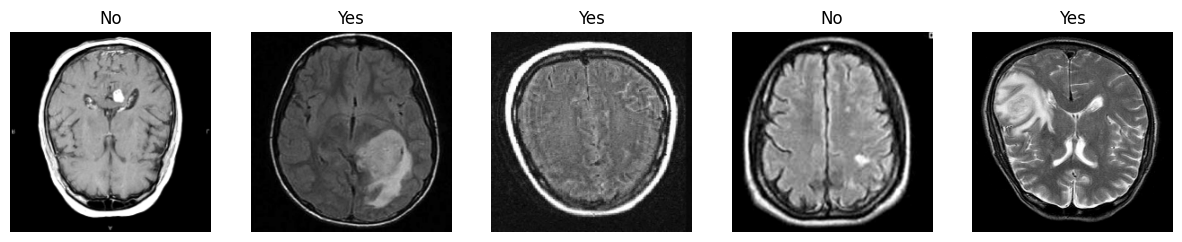

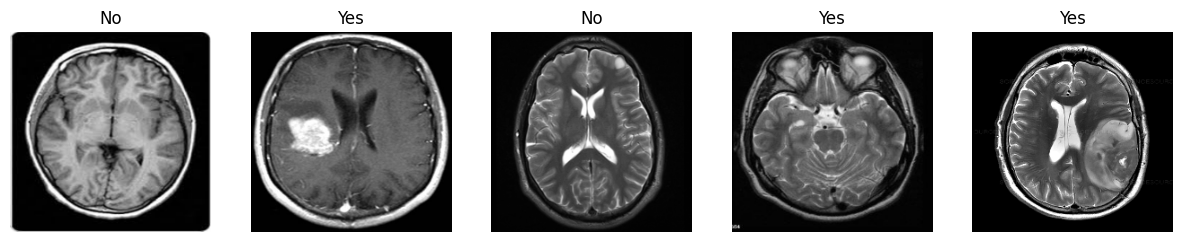

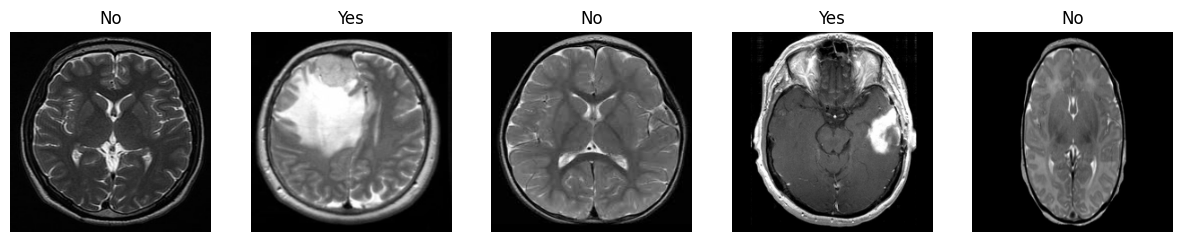

In [ ]:
# Visualize a given number of samples from the training set
visualize_samples(train_dataset, num_samples=5)
visualize_samples(val_dataset, num_samples=5)
visualize_samples(test_dataset, num_samples=5)

In [ ]:
# Create data loaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
#the model
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)

        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()


        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x




class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)



def ResNet50(num_classes, channels=1):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

def ResNet101(num_classes, channels=1):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=1):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

In [ ]:
model = ResNet101(NUM_CLASSES)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function=F.cross_entropy
torch.cuda.empty_cache()

In [ ]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    predicted_labels_2d=[]
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        predicted_labels_2d.append(predicted_labels)
    return (torch.tensor(correct_pred, dtype=torch.float) / torch.tensor(num_examples, dtype=torch.float) * 100), predicted_labels_2d


In [ ]:
torch.cuda.empty_cache()

In [ ]:
#training loop
for epoch in range(NUM_EPOCHS):
    # Performing Training for each epoch
    training_loss = 0.
    model.train()
    # The training loop
    for batch in train_loader:
        optimizer.zero_grad()
        input, label = batch
        input = input.to(DEVICE)
        label = label.to(DEVICE)

        output = model(input)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()


    # Performing Validation for each epoch
    validation_loss = 0.
    model.eval()

    # The validation loop
    for batch in val_loader:
        input, label = batch
        input = input.to(DEVICE)
        label = label.to(DEVICE)
        output = model(input)
        loss = loss_function(output, label)
        validation_loss += loss.item()

    # Calculating the average training and validation loss over epoch
    training_loss_avg = training_loss/len(train_loader)
    validation_loss_avg = validation_loss/len(val_loader)
    train_acc,_=compute_accuracy(model, train_loader, device=DEVICE)
    val_acc,_=compute_accuracy(model, val_loader, device=DEVICE)

    # Printing average training and average validation losses
    print("Epoch: {}".format(epoch+1))
    print("Training loss: {}".format(training_loss_avg))
    print("Validation loss: {}".format(validation_loss_avg))
    print('Epoch: %03d/%03d | Train: %.3f%%' % (epoch+1, NUM_EPOCHS, train_acc))
    print('Epoch: %03d/%03d | Val: %.3f%%' % (epoch+1, NUM_EPOCHS, val_acc))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
<ipython-input-31-ade40d84296f>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(correct_pred, dtype=torch.floa

Epoch: 1
Training loss: 0.8658542335033417
Validation loss: 0.6301804780960083
Epoch: 001/050 | Train: 61.326%
Epoch: 001/050 | Val: 61.905%
Epoch: 2
Training loss: 0.6185517112414042
Validation loss: 0.6285806596279144
Epoch: 002/050 | Train: 61.326%
Epoch: 002/050 | Val: 61.905%
Epoch: 3
Training loss: 0.6060812597473463
Validation loss: 0.6235228776931763
Epoch: 003/050 | Train: 64.088%
Epoch: 003/050 | Val: 66.667%
Epoch: 4
Training loss: 0.5882194116711617
Validation loss: 0.5630489587783813
Epoch: 004/050 | Train: 73.481%
Epoch: 004/050 | Val: 66.667%
Epoch: 5
Training loss: 0.5518911257386208
Validation loss: 0.5534109622240067
Epoch: 005/050 | Train: 75.138%
Epoch: 005/050 | Val: 71.429%
Epoch: 6
Training loss: 0.5237016081809998
Validation loss: 0.6694562435150146
Epoch: 006/050 | Train: 77.901%
Epoch: 006/050 | Val: 76.190%
Epoch: 7
Training loss: 0.4828873698910077
Validation loss: 0.7073405310511589
Epoch: 007/050 | Train: 77.901%
Epoch: 007/050 | Val: 76.190%
Epoch: 8
Trai

In [ ]:
with torch.set_grad_enabled(False):
    acc,predicted_labels=(compute_accuracy(model, test_loader, device=DEVICE))
    print('Test accuracy: %.2f%%' % acc)

Test accuracy: 80.39%


<ipython-input-31-ade40d84296f>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(correct_pred, dtype=torch.float) / torch.tensor(num_examples, dtype=torch.float) * 100), predicted_labels_2d


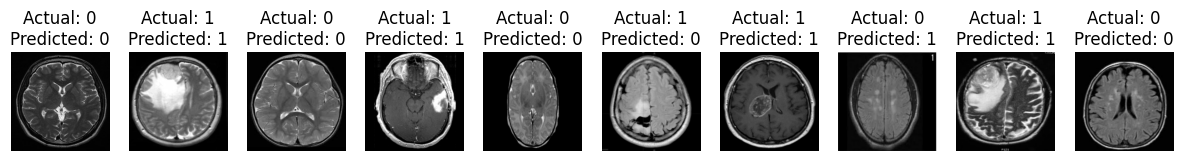

In [ ]:
def visualize_predictions(test_dataset, model, device):
    model.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(1, 10,figsize=(15, 3))

        for i in range(10):
            image, label = test_dataset[i]
            image = image.unsqueeze(0).to(device)
            label = label.item()

            output = model(image)
            _, predicted_label = torch.max(output, 1)
            predicted_label = predicted_label.item()

            axes[i].imshow(transforms.ToPILImage()(image.squeeze()), cmap='gray')
            axes[i].set_title(f"Actual: {label}\nPredicted: {predicted_label}")
            axes[i].axis('off')

        plt.show()

visualize_predictions(test_dataset, model, DEVICE)
